# Disclaimer: This notebook is my version of the "A Cloud Guru ufo-algorithms-lab " which can be found here [Github](https://github.com/ACloudGuru-Resources/Course_AWS_Certified_Machine_Learning/blob/master/Chapter7/ufo-algorithms-lab.ipynb)
## I apply my own implementation during all steps in the Work Flow 


# Introduction 
## Problem Definition :
We want to build out models to predict the legitimacy of a UFO sighting based on the given info about them.
## ML Objectives :
Using the Supervised Learning approach for building out Multiclass Classification models using the Amazon SageMaker built-in algorithms such as XGBoast and Linear Learners 




# Step 0: Importing Libraries 

In [1]:
# Run this cell to install Pandas Profiling library
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install  fsspec==0.7.4 


     \ 34.5 MB 660 kB/s
     |████████████████████████████████| 75 kB 866 kB/s  eta 0:00:01
     |████████████████████████████████| 11.5 MB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 594 kB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 57.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 191 kB/s  eta 0:00:01
     |████████████████████████████████| 295 kB 61.3 MB/s eta 0:00:01
  Created wheel for pandas-profiling: filename=pandas_profiling-2.10.1-py2.py3-none-any.whl size=240608 sha256=71cc253380c796835d1d3e5600d04990c10b53f99200432c38ce40443b6fccb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qb4u7g4r/wheels/b2/af/cb/ca484c1ce66cdc8b79923c05f88baf514e553437bdc6b334f2
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27084 sha256=d511ad740eac1a2af0a529f255ffbef1434

In [2]:
#classical Data science libraries 
import pandas as pd 
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import io 
from datetime import datetime 
%matplotlib inline

# Sagemaker libraries 
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role


# Step 1: Loading data from S3 

In [48]:
# define data location 
role = get_execution_role()
bucket = "ufo1991"
sub_folder= "ufo_dataset" # Prefix
data_key = "ufo_fullset.csv" #S3 object
data_location = "s3://{}/{}/{}".format(bucket, sub_folder, data_key)
#read data and see the first 10 observations
df = pd.read_csv(data_location, low_memory=False)
df.head(10)

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained
5,2011-08-14T23:27:37.734Z,2011-08-13,02:55,sphere,65,1,partly cloudy,Kellen,Smitham,33.916389,-118.351667,Y,N,N,explained
6,1991-02-06T11:02:39.883Z,1991-02-05,14:04,triangle,80,1,partly cloudy,Hilton,Purdy,33.669444,-117.822222,Y,N,N,probable
7,1973-01-02T11:51:04.056Z,1972-12-31,22:56,light,33,1,rain,Zita,Johns,44.716667,-75.516667,Y,N,N,unexplained
8,2004-12-09T08:37:11.338Z,2004-12-07,22:07,pyramid,22,1,partly cloudy,Alexane,Schneider,40.866667,-124.081667,Y,N,N,explained
9,1994-11-21T13:36:50.772Z,1994-11-15,17:20,disk,72,1,fog,Oswaldo,Schumm,47.130278,-119.276944,Y,N,N,explained


# Step 2: EDA and Data Preparation

## 2.0 Checking for Missing Values & Handling them .

In [4]:
missing_values = df.isnull().values.any()
if (missing_values):
    display(df[df.isnull().any(axis=1)])

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
1024,2011-03-23T18:32:20.473Z,2011-03-22,21:12,NaN,3,1,rain,Deon,Feil,37.681944,-121.766944,Y,N,N,explained
2048,1998-04-23T18:47:16.029Z,1998-04-23,10:07,NaN,40,2,partly cloudy,Vincenzo,Rohan,38.254167,-85.759444,Y,Y,N,explained


### It is clear that we have a clean dataset that contains only 2 observations with missing values, hence, we will can drop them out or imput them with the most common value .
> In our case, we can replace the missed shape values with the mode value.


In [5]:
# finding the most common value (Mode)
df["shape"].describe()

count      17998
unique         9
top       circle
freq        6047
Name: shape, dtype: object

In [49]:
#filling null (NaN) values of the shape attribute with Circle 
df["shape"] = df["shape"].fillna("circle")


In [7]:
# double check for missing values 
missing_values = df.isnull().values.any()
if (missing_values):
    display(df[df.isnull().any(axis=1)])
else :
    print ("Your dataset doesn't contain missing values, Go ahead!")

Your dataset doesn't contain missing values, Go ahead!


## 2.1 Explore our data to figure out required Data preparation Steps 

In [8]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()



Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### From our automated EDA using panadas profiling, we can reveal that  : 
**Feature Selection**
> * 1."sighting" attribute must be dropped because it is constant value 
> * 2."firstName" & "lastName"attributes shoud be dropped because it does not make any sense that person name is important
> * 3. Do further analysis to see what features should be selected

**Feature engineering**
> * 4.we have non-numerical data that need to be transformed 
> * 5.We have date and time data that need to be parased into proper date time format


**Percautions**
> * 6. Our target "researchOutcome" has imblanced distribution among the three classes 
> * 7. We have geo spatial data that need to be handeled with caution.
> * 8. We need further preparation steps to match the required Input format for the SageMaker Algorithms  

## 2.2 Further EDA 


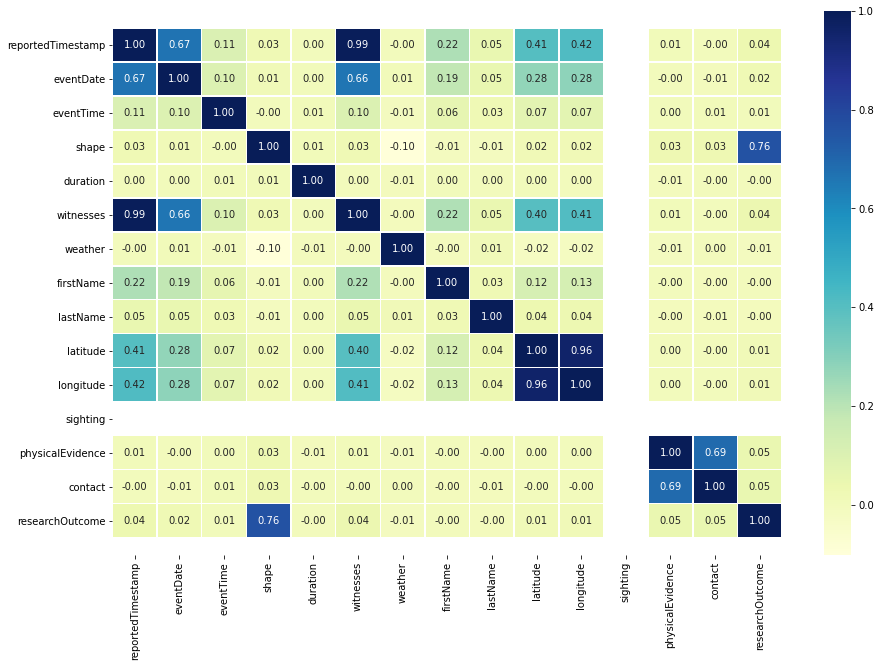

In [9]:
# Lets visualize correlation matrix using the heatmap instead of looking at the correlation coeffiecients only!

corr_max = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1) # to include non-numerical features

fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_max,
              annot = True,
               linewidth = 0.5,
              fmt = ".2f",
              cmap = "YlGnBu")
# to correct bottom and top cut
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);


### **It is obvious that the "shape" attribute is the only highly correlated feature with our Target! so, we should pay extra attention on It.** 

> ### Univariate Analysis of " shape" attribute

In [10]:
# Summary statistics 
df["shape"].describe()

count      18000
unique         9
top       circle
freq        6049
Name: shape, dtype: object

circle      6049
disk        5920
light       1699
square      1662
triangle    1062
sphere      1020
box          200
oval         199
pyramid      189
Name: shape, dtype: int64

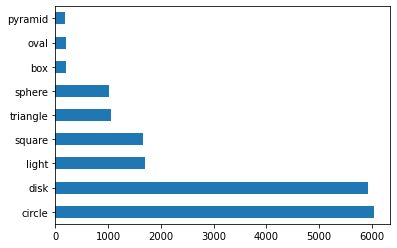

In [11]:
df["shape"].value_counts().plot(kind="barh")
df["shape"].value_counts()


###  It is obvious that :
> *  ### 1.Shape is in object format and we need to tranform it into categorical format to apply Categorical Encoding which is required for Linear Learner Model
> *  ### 2.We can map "box & oval & Pyramid " shapes into "other" to reduce the complexity when we apply Categorical Encoding
> *  ### 3.With the same previous logic we can apply grouping on the following pairs "circle & disk" , "light & Square " , "traingle & sphere" but after reviewing the relatioship between "shape" and "Target"

### Bivariate analysis of "shape" and "research Outcome (Target)"

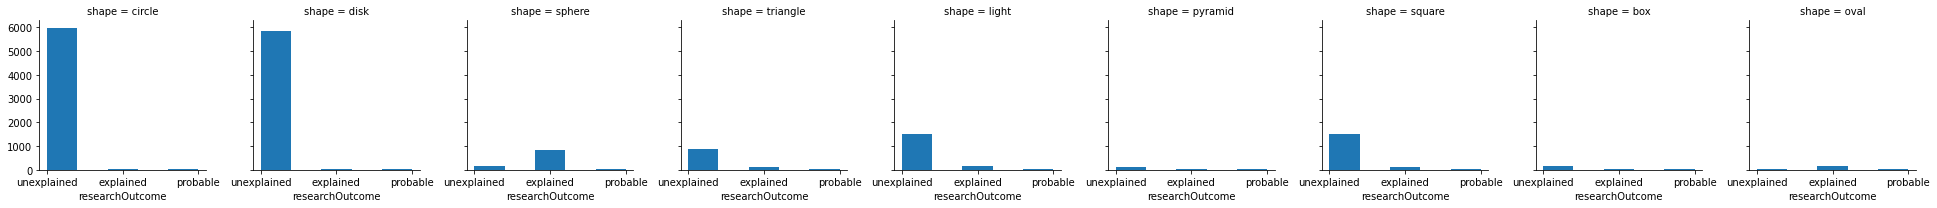

In [12]:
# You can double click on the figure to zoom in
g = sns.FacetGrid(df, col='shape')
g.map(plt.hist, 'researchOutcome', bins=5)

> **We can not group sphere & triangle in one category because thier impact on the research outcome is completely differnt, and we are sure that other groupings we suggested in the previous step are valid** .

### Univariate Analysis of Latitude and Longitude 

count    18000.000000
mean        37.768656
std         10.074287
min        -46.163992
25%         33.990833
50%         38.901111
75%         42.271111
max         70.416667
Name: latitude, dtype: float64

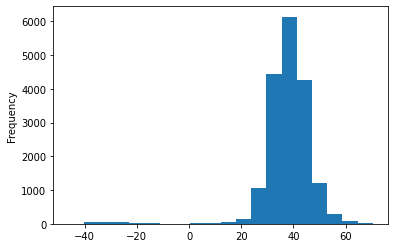

In [13]:
df["latitude"].plot(kind="hist", bins= 20);

df["latitude"].describe()

count    18000.000000
mean       -87.034487
std         38.837258
min       -169.541667
25%       -111.840556
50%        -87.841806
75%        -79.121667
max        178.441900
Name: longitude, dtype: float64

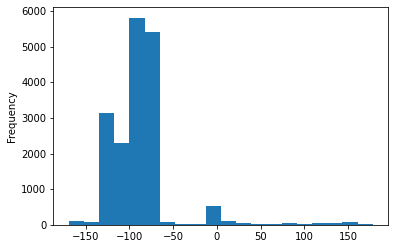

In [14]:
df["longitude"].plot(kind="hist", bins=20);
df["longitude"].describe()

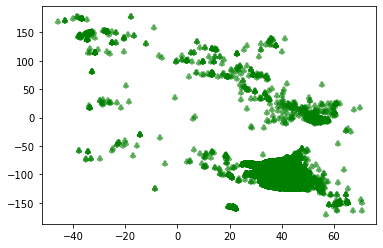

In [15]:
plt.scatter(df["latitude"], df["longitude"], c="g", alpha=0.5, marker=r'$\clubsuit$')



### We can conclude that most of observations lie within  particular geographic regions, we can know them using Geopy library to reverse the lat & long into addresses [here](https://geopy.readthedocs.io/en/latest/#module-geopy.geocoders)

## 2.3 Feature Engineering

### After running our EDA, we can drop the following features :
> * 1. "sighting" because it has only one value 
> * 2. "firstName" & "lastName" because it does not make any sense to include the name in our training data !
> * 3. "reportedTimestamp" & "eventDate" & "eventTime" because they are high cardinal features with almost unique values


In [52]:
df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

### Transformation steps will be as following :
> * (shape & weather & researchOutcome ) to category format
> * (physicalEvidence & contact ) to binary format.
> * (longitude & latitude ) to integer format


In [53]:
# explore our data types 
df.dtypes

shape               category
duration               int64
witnesses              int64
weather             category
latitude               int64
longitude              int64
physicalEvidence       int64
contact                int64
researchOutcome     category
dtype: object

In [50]:

# To categorical format
df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')
df['researchOutcome'] = df['researchOutcome'].astype('category')
# To binary format

df['physicalEvidence'] = df['physicalEvidence'].replace({'Y': 1, 'N': 0})
df['contact'] = df['contact'].replace({'Y': 1, 'N': 0})

# To integer format
df['longitude'] = df['longitude'].astype(int)
df['latitude'] = df['latitude'].astype(int)


In [54]:
# double checking for our data types
df.dtypes

shape               category
duration               int64
witnesses              int64
weather             category
latitude               int64
longitude              int64
physicalEvidence       int64
contact                int64
researchOutcome     category
dtype: object

### Categorical Encoding 

### before we encode shape, we will grouping some shapes as mentioned before

In [55]:
shape = {'circle'   :"circle or disk",
         'disk'     :"circle or disk",
         'triangle' :"triangle or sphere",
         'sphere'   :"triangle or sphere",
         'box'      :"other",
         'oval'     :"other",
         'pyramid'  :"other"}

In [57]:
df["shape"].replace(shape, inplace=True)
df.head()

,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle or disk,4,1,rain,47,-122,0,0,explained
1,circle or disk,4,1,partly cloudy,52,-1,1,0,explained
2,circle or disk,49,1,clear,38,-92,0,0,explained
3,circle or disk,13,1,partly cloudy,41,-71,0,0,explained
4,circle or disk,17,1,mostly cloudy,47,-122,0,0,explained


In [58]:
# Let's one-hot the weather and shape attribute
df = pd.get_dummies(df, columns=['weather', 'shape'])

# Let's replace the researchOutcome values with 0, 1, 2 for Unexplained, Explained, and Probable
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

In [59]:
df.head()

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,weather_partly cloudy,weather_rain,weather_snow,weather_stormy,shape_circle or disk,shape_light,shape_other,shape_square,shape_triangle or sphere
0,4,1,47,-122,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
1,4,1,52,-1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
2,49,1,38,-92,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
3,13,1,41,-71,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,17,1,47,-122,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


## 2.4 Further Data Preparation
This is the last data preparation stage which involve the following steps:
> * 1. **Shuffling** & **Spliting**  data into train , validate and test sets
> * 2. **Droping** Target columns from validation and test dataset
> * 3. **Edit** the structure of the dataset to match the required input of the built-in algorithms
> * 4. **Upload** our modifiied dataset onto S3 


###  Shuffling and Splitting

In [60]:
# Let's go ahead and randomize our data.
df = df.sample(frac=1, random_state= 42).reset_index(drop=True) # random_state for reproducibility

# Next, Let's split the data into a training, validation, and testing.
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.7                       # 70% for training
val_list = (rand_split >= 0.7) & (rand_split < 0.85) # 15% for validation
test_list = rand_split >= 0.85                       # 15% for testing

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]


### Droping and Editing

In [61]:

# Simply moves the researchOutcome attribute to the first position before creating CSV files
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

### Uploading

In [62]:
# Next we can take the files we just stored onto our Notebook instance and upload them to S3.
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_validation/validation.csv').upload_file('validation.csv')

# Step 3: Training using XGB 

We will use the XGB built-in algorithm from Amazon. So, we wiil do the following steps :
> * 1. **Retrieve** a docker image from the ECR that holds it.
> * 2. **Pointing** to our data so that algorithm can use it as input.
> * 3. **Creating** training job with the prefered parameters.
> * 4. **Setting** up our hyperparameters configuration.
> * 5. **Naming** our data channels (training & validation dataset pointers)
> * 6. **Starting** training using Fit method.


### 3.1 Retrieving our docker image

In [63]:
from sagemaker import image_uris
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1') # "1" refer to the most stable version

### 3.2 Pointing to our data

In [64]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/algorithms_lab/xgboost_train'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/algorithms_lab/xgboost_validation'.format(bucket), content_type='csv')

### 3.3 Creating training job 

In [67]:
# Create a training job name
job_name = 'ufo-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model artifact will be stored
output_location = 's3://{}/algorithms_lab/xgboost_output'.format(bucket)
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

Here is the job name ufo-xgboost-job-20210213135239


### 3.4 Setting hyper parameters

In [68]:
xgb.set_hyperparameters(objective='multi:softmax', #softmax because we are solving a multi-class classification problem
                        num_class=3, # we have 3 classes
                        num_round=100) # we will run 100 iterations 

### 3.5 Naming our data channels

In [69]:
data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}

### 3.6 Starting training (Fitting)

In [70]:
xgb.fit(data_channels, job_name=job_name)
print('Here is the location of the trained XGBoost model: {}/{}/output/model.tar.gz'.format(output_location, job_name))


2021-02-13 13:57:46 Starting - Starting the training job...
2021-02-13 13:57:49 Starting - Launching requested ML instancesProfilerReport-1613224666: InProgress
......
2021-02-13 13:59:01 Starting - Preparing the instances for training......
2021-02-13 14:00:10 Downloading - Downloading input data...
2021-02-13 14:00:44 Training - Training image download completed. Training in progress..Arguments: train
[2021-02-13:14:00:44:INFO] Running standalone xgboost training.
[2021-02-13:14:00:44:INFO] File size need to be processed in the node: 0.62mb. Available memory size in the node: 8440.74mb
[2021-02-13:14:00:44:INFO] Determined delimiter of CSV input is ','
[14:00:44] S3DistributionType set as FullyReplicated
[14:00:44] 12637x18 matrix with 227466 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-02-13:14:00:44:INFO] Determined delimiter of CSV input is ','
[14:00:44] S3DistributionType set as FullyReplicated
[14:00:44] 2681x18 matrix with 48258 entr